In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

In [2]:
df = pd.read_csv('msft.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1,1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
2,1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
3,1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
4,1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...,...
9400,2023-06-30,337.750000,342.730011,337.200012,340.540009,340.540009,26823800
9401,2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700
9402,2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400
9403,2023-07-06,337.299988,342.989990,335.500000,341.269989,341.269989,28161200


In [3]:
def str_to_date(s):
    split = s.split('-')
    y,m,d = int(split[0]), int(split[1]), int(split[2])
    return datetime.datetime(year = y, month  = m, day = d)



In [4]:
df['Date'] = df['Date'].apply(str_to_date)
df['Date']

0      1986-03-13
1      1986-03-14
2      1986-03-17
3      1986-03-18
4      1986-03-19
          ...    
9400   2023-06-30
9401   2023-07-03
9402   2023-07-05
9403   2023-07-06
9404   2023-07-07
Name: Date, Length: 9405, dtype: datetime64[ns]

In [5]:
df.index = df.pop('Date')
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1986-03-13,0.088542,0.101563,0.088542,0.097222,0.060524,1031788800
1986-03-14,0.097222,0.102431,0.097222,0.100694,0.062686,308160000
1986-03-17,0.100694,0.103299,0.100694,0.102431,0.063767,133171200
1986-03-18,0.102431,0.103299,0.098958,0.099826,0.062145,67766400
1986-03-19,0.099826,0.100694,0.097222,0.098090,0.061065,47894400
...,...,...,...,...,...,...
2023-06-30,337.750000,342.730011,337.200012,340.540009,340.540009,26823800
2023-07-03,339.190002,340.899994,336.570007,337.989990,337.989990,12508700
2023-07-05,335.089996,341.649994,334.730011,338.149994,338.149994,18172400


In [23]:
def df_to_windowed_df(dataframe, first_date_str, last_date_str, n=3):
  first_date = str_to_date(first_date_str)
  last_date  = str_to_date(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close'].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df

windowed_df = df_to_windowed_df(df,
                                '2021-03-25',
                                '2023-06-09',
                                n=3)
windowed_df

,Target Date,Target-3,Target-2,Target-1,Target
0,2021-03-25,235.990005,237.580002,235.460007,232.339996
1,2021-03-26,237.580002,235.460007,232.339996,236.479996
2,2021-03-29,235.460007,232.339996,236.479996,235.240005
3,2021-03-30,232.339996,236.479996,235.240005,231.850006
4,2021-03-31,236.479996,235.240005,231.850006,235.770004
...,...,...,...,...,...
552,2023-06-05,328.390015,332.579987,335.399994,335.940002
553,2023-06-06,332.579987,335.399994,335.940002,333.679993
554,2023-06-07,335.399994,335.940002,333.679993,323.380005
555,2023-06-08,335.940002,333.679993,323.380005,325.260010


In [24]:
def windowed_df_to_date(windowed_df):
    df_np = windowed_df.to_numpy()
    dates = df_np[:,0]
    targets = df_np[:,1:-1]
    X = targets.reshape(len(dates), targets.shape[1],1)
    Y = df_np[:,-1]
    return dates, X.astype(np.float32), Y.astype(np.float32)
dates,x,y = windowed_df_to_date(windowed_df)
dates.shape, x.shape, y.shape

((557,), (557, 3, 1), (557,))

In [29]:
q80 = int(len(dates) * 0.8)
q90 = int(len(dates) * 0.9)

dates_train , x_train, y_train = dates[:q80], x[:q80], y[:q80]
dates_test, x_test, y_test = dates[q90:], x[q90:], y[q90:]
dates_val, x_val, y_val = dates[q80:q90], x[q80:q90], y[q80:q90]

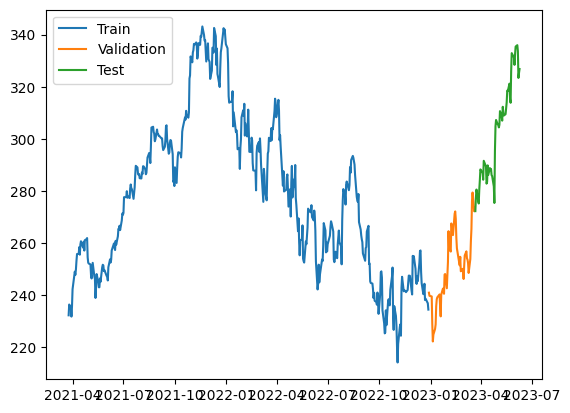

In [30]:
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100)

Epoch 1/100
14/14 [==============================] - 4s 56ms/step - loss: 77459.2109 - mean_absolute_error: 276.6792 - val_loss: 62234.1250 - val_mean_absolute_error: 249.0943
Epoch 2/100
14/14 [==============================] - 0s 7ms/step - loss: 76392.4375 - mean_absolute_error: 274.7533 - val_loss: 61112.0742 - val_mean_absolute_error: 246.8317
Epoch 3/100
14/14 [==============================] - 0s 7ms/step - loss: 74898.0312 - mean_absolute_error: 272.0117 - val_loss: 59409.3438 - val_mean_absolute_error: 243.3575
Epoch 4/100
14/14 [==============================] - 0s 7ms/step - loss: 72305.8906 - mean_absolute_error: 267.1836 - val_loss: 55998.4922 - val_mean_absolute_error: 236.2450
Epoch 5/100
14/14 [==============================] - 0s 8ms/step - loss: 67533.2656 - mean_absolute_error: 258.1203 - val_loss: 50794.7227 - val_mean_absolute_error: 224.9624
Epoch 6/100
14/14 [==============================] - 0s 7ms/step - loss: 60867.2109 - mean_absolute_error: 244.8325 - val_lo

14/14 [==============================] - 1s 2ms/step


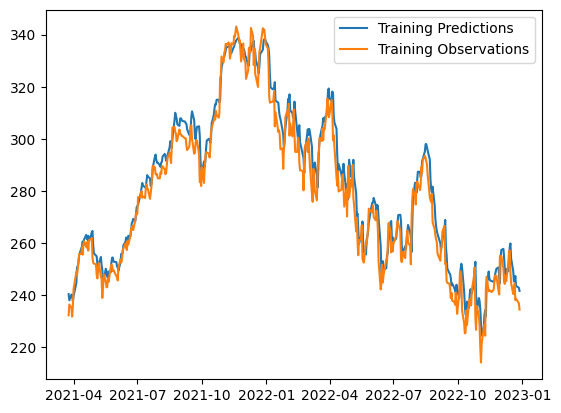

In [33]:
train_predictions = model.predict(x_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 4ms/step


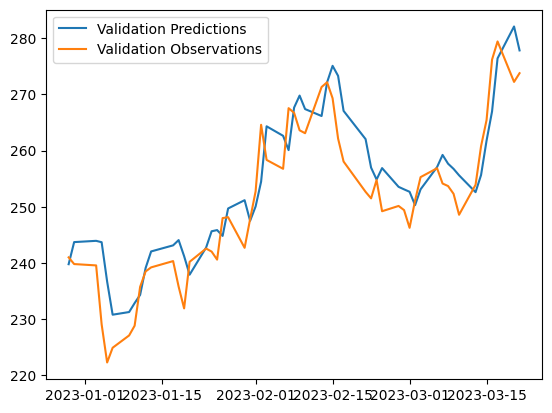

In [35]:
val_predictions = model.predict(x_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])